### Tensor Flow 2-11 notebook

Notes: 
- Notebook should be running with an Nvidia GPU to for top performance
- load_img will load a nparray with x, y, 3 color dims.  
- If we're just processing one image we will need to np.expand_dims(image, axies=0) to get 1, x, y, 3. The library expects N images in the first dim
- should set random seed on tf.random.set_seed(1) for reproduceability 
- 

last change 3/6/2025

In [9]:
# import the libraries for training, testing, validation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import imagenet_utils  # will decode predictions out of the model into a 4 dim array of N (image num), imageID, label, probability result[0] would be the set of results for image one
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img  # will load img and reshape, usage is load_img(image_name_loc, target_size=input_shape)
from tensorflow.keras.utils import plot_model  # Note: usage syntax is plot_model(instantied_model, to_file='', show_shapes=True)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds  # For loading datasets from GCS


import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import time


In [2]:
# ??? need to switch to dict variables below
# Configuration
GCS_BUCKET = 'nabirds_filtered'  
DATASET_PATH = 'images'  # Relative path within the bucket
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
epochs = 5
NUM_CLASSES = None  # determined from the dataset

In [3]:
# define a dictionary for model config and experiment tracking.... 
model_input_variables = {
    "EfficientNetB0": {
        "image_size": (224, 224),
        "batch_size": 32,
        "epochs": 10,
        "learning_rate": 0.0001,
    },
    "MobileNetV2": {
        "image_size": (224, 224),
        "batch_size": 32,
        "epochs": 10,
        "learning_rate": 0.0001,
    },
     "MobileNetV3Large": { #MobileNetV3 Large will be used to compare accuracy loss with small, prob not a candidate for rasp pi running
        "image_size": (224, 224),
        "batch_size": 32,
        "epochs": 10,
        "learning_rate": 0.0001,
    },
    "MobileNetV3Small":{ 
        "image_size": (224, 224),
        "batch_size": 32,
        "epochs": 10,
        "learning_rate": 0.0001,
    },
    "InceptionV3": {
        "image_size": (299, 299),  # InceptionV3 typically uses 299x299
        "batch_size": 32,
        "epochs": 10,
        "learning_rate": 0.0001,
    },
    "EfficientNetB7":{
        "image_size": (600,600),  # big values!
        "batch_size": 16, # this is a larger model and the norm seems to be smaller batch sizes for reduced memory use
        "epochs": 10,
        "learning_rate": 0.0001,
    }
}

print(f'EfficientNetB0: {model_input_variables["EfficientNetB0"]}')
print(f'MobileNetV2: {model_input_variables["MobileNetV2"]}')
print(f'MobileNetV3Large: {model_input_variables["MobileNetV3Large"]}')
print(f'MobileNetV3Small: {model_input_variables["MobileNetV3Small"]}')
print(f'InceptionV3: {model_input_variables["InceptionV3"]}')
print(f'EfficientNetB7: {model_input_variables["EfficientNetB7"]}')

EfficientNetB0: {'image_size': (224, 224), 'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001}
MobileNetV2: {'image_size': (224, 224), 'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001}
MobileNetV3Large: {'image_size': (224, 224), 'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001}
MobileNetV3Small: {'image_size': (224, 224), 'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001}
InceptionV3: {'image_size': (299, 299), 'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001}
EfficientNetB7: {'image_size': (600, 600), 'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0001}


In [4]:
def write_results_to_file(filename, start_time, end_time, model_name, batch_size, epochs, image_size, training_accuracy, test_accuracy, training_loss, test_loss):
    start_time_str = start_time.strftime("%Y-%m-%d %H:%M:%S")
    end_time_str = end_time.strftime("%Y-%m-%d %H:%M:%S")
    line = f"{start_time_str},{end_time_str},{model_name},{batch_size},{epochs},{image_size},{training_accuracy},{test_accuracy},{training_loss},{test_loss}\n"
    if not os.path.exists(filename):      # Check if the file exists, and add a header if it's new
        header = "start_time,end_time,model_name,batch_size,epochs,image_size,training_accuracy,test_accuracy,training_loss,test_loss\n"
        with open(filename, "w") as f:
            f.write(header + line)
    else:
        with open(filename, "a") as f: # or append to existing file
            f.write(line)
    print(f'experiment tracking updated')
    return

In [5]:
def load_gcs_dataset(bucket_name, dataset_path, image_size, batch_size):
    dataset = None
    gcs_dataset_path = f"gs://{bucket_name}/{dataset_path}"
    try:
        dataset = keras.utils.image_dataset_from_directory(gcs_dataset_path, image_size=image_size,
            batch_size=batch_size, label_mode='categorical',)  # categorical is for softmax layer
    except Exception as e:
        print(f"Error loading dataset from GCS: {e}")    
    return dataset


In [6]:
# split into its own cell so we do not have to repeat this long operation, 
# ??? will need to be in loop for batch_size changes
start_time = time.time()
start_time_datetime = datetime.datetime.fromtimestamp(start_time)
print(f'Start time: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')

train_dataset = load_gcs_dataset(GCS_BUCKET, os.path.join(DATASET_PATH, 'train'), IMAGE_SIZE, BATCH_SIZE)
validation_dataset = load_gcs_dataset(GCS_BUCKET, os.path.join(DATASET_PATH, 'test'), IMAGE_SIZE, BATCH_SIZE)

if train_dataset is None or validation_dataset is None:
    print("Dataset loading failed. Exiting.")
    exit()
num_classes = len(train_dataset.class_names) # Get class count.

Found 2455 files belonging to 27 classes.


2025-03-12 00:14:11.095279: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-03-12 00:14:11.095311: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-12 00:14:11.095333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bird-feeder-profiling-2024-2025): /proc/driver/nvidia/version does not exist
2025-03-12 00:14:11.098849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To ena

Found 621 files belonging to 27 classes.


Start time: 2025-03-12 00:38:01
Epoch 1/5
77/77 [==============================] - 121s 1s/step - loss: 1.9707 - accuracy: 0.4933 - val_loss: 2.9952 - val_accuracy: 0.1868
Epoch 2/5
77/77 [==============================] - 107s 1s/step - loss: 0.4720 - accuracy: 0.8807 - val_loss: 2.2797 - val_accuracy: 0.3833
Epoch 3/5
77/77 [==============================] - 106s 1s/step - loss: 0.1601 - accuracy: 0.9760 - val_loss: 1.8447 - val_accuracy: 0.4879
Epoch 4/5
77/77 [==============================] - 106s 1s/step - loss: 0.0678 - accuracy: 0.9931 - val_loss: 1.4267 - val_accuracy: 0.5765
Epoch 5/5
77/77 [==============================] - 105s 1s/step - loss: 0.0317 - accuracy: 0.9984 - val_loss: 1.1302 - val_accuracy: 0.6409


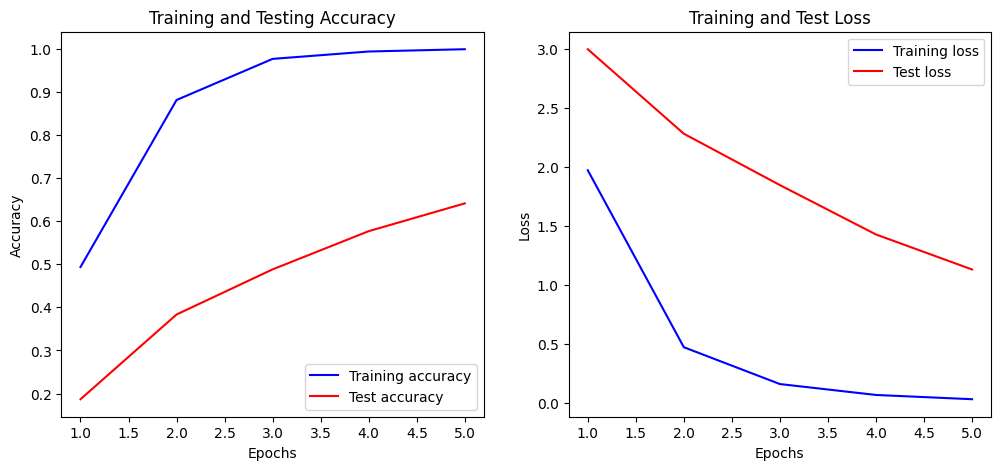

End time: 2025-03-12 00:47:08


In [10]:
# ?? code needs to be changed for experiment tracking and different model types

##### MobileNetV2 training sample, use for comparision to old model in feeder
start_time = time.time()
start_time_datetime = datetime.datetime.fromtimestamp(start_time)
print(f'Start time: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')

###### load mobilenetv2 and modify head
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # unlock top layer for softmax replacement
base_model.trainable = True  # Unlock the base model, note this should be changed to freeze some layers per lit review ??

# add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Optional: Add more dense layers
predictions = Dense(num_classes, activation='softmax')(x)

# create the model with Rescaling layer
inputs = base_model.input
rescaled_inputs = tf.keras.layers.Rescaling(1./255)(inputs)  # normalize pixel values to [0, 1], not sure if this was done in the old mobilenetv2 model
x = base_model(rescaled_inputs) # pass the rescaled input through the base model
model = Model(inputs=inputs, outputs=predictions) # use the original inputs, this is weird, but how it was done in tutorial...

# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  # Important for multi-class classification
              metrics=['accuracy'])

# train the model
history = model.fit(train_dataset, epochs=epochs, initial_epoch=0, validation_data=validation_dataset)  # initial epoch=0 is traing from scratch

# save model
model.save('mobilenet_retrained.h5')

# plot results, error here means model did not train
acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
loss = history.history['loss']
test_loss = history.history['val_loss']

epochs_plt = range(1, len(acc) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_plt, acc, 'b', label='Training accuracy')
plt.plot(epochs_plt, test_acc, 'r', label='Test accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_plt, loss, 'b', label='Training loss')
plt.plot(epochs_plt, test_loss, 'r', label='Test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# record training time
end_time = time.time()
end_time_datetime = datetime.datetime.fromtimestamp(end_time)
print(f'End time: {end_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
